# Diffusion 扩散模型 之 DPM


这是 diffusion 扩散模型系列第四部分，介绍扩散模型的早期雏形 DPM。

早在2015年，Sohl-Dickstein等人发表了一篇很有趣的论文“使用非平衡热力学进行深度无监督学习”（“Deep Unsupervised Learning using Nonequilibrium Thermodynamics）”论文中写道，可以使用统计力学的摄动方法，通过反向方法可以将噪声还原成原始分布。

本部分包括以下内容：
  1. 简介
  2. 前向过程
  3. 反向过程
  4. 模型训练\
     4.1 损失函数\
     4.2 训练方法
  
笔记参考：https://github.com/acids-ircam/diffusion_models

## 1 简介

扩散模型最早由 Sohl-Dickstein et al. [ [ 1 ] ](#ref1)提出，根据非平衡热力学，提出基于随机变量的两个马尔可夫链的正反过程的模型，其中一个过程 $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ 逐步向输入数据中增加噪声(称为扩散或者前向过程)，将信号转成噪声；而反向过程 $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ 尝试将扩散过程逆转回来(将随机噪声转成信号)，下图描述了这两个过程：

<img src=attachment:image.png 
     width="100%"/>

可以看出，前向过程 $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ 是固定的，逐步给每个时间步增加噪声。相反的，反向过程 $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ 需要学会如何解噪。因此，学习涉及估计很多数量的小噪声，这比尝试使用单个潜在函数直接估计完整分布更容易处理。

两个过程都可被视为马尔可夫链, 但是扩散过程通常是给每个时间步注入给定数量的噪声，而反向过程使用变分推断进行训练，可以使用条件高斯概率模型，这样可以使用神经网路参数化建模。

扩散模型是基于一系列隐变量 $ \mathbf{x}_{1},\cdots,\mathbf{x}_{T}$ ，这些隐变量与输入数据有相同的维度，定义如下2个过程：

$$
\text{forward (diffusion)} : q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$
$$
\text{reverse (parametric)} : p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$
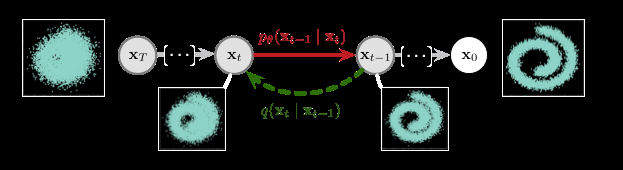

## 2 前向过程

在前向过程中, 数据 $q(\mathbf{x}_{0})$ 会逐渐转换成 $\pi(\mathbf{y})$, 重复使用马尔可夫 diffusion kernel $T_{\pi}(\mathbf{y}\mid\mathbf{y}';\beta)$, 其中扩散率 $\beta$ 是给定的：

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = T_{\pi}(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}; \beta_{t})
$$

diffusion kernel 可以设置为逐步加入高斯噪声, 给定 variance schedule $\beta_{1},\cdots,\beta_{T}$ ：

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

完整的分布 $q(\mathbf{x}_{0:T})$ 被称为扩散过程，定义如下：

$$
q(\mathbf{x}_{0:T}) =  q(\mathbf{x}_{0}) \prod_{t=1}^{T} q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$

这里我们使用不变的 variance schedule，看看 naive 前向扩散过程是怎样计算的：

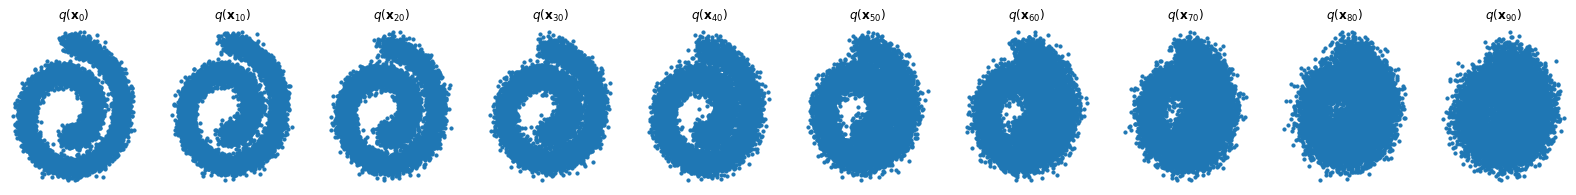

In [1]:
import torch
import matplotlib.pyplot as plt
from utils.helper import sample_batch

def forward_process(x_start, n_steps, noise=None):
    """ Diffuse the data (t == 0 means diffused for 1 step) """
    x_seq = [x_start]
    for n in range(n_steps):
        x_seq.append((torch.sqrt(1 - betas[n]) * x_seq[-1]) + (betas[n] * torch.rand_like(x_start)))
    return x_seq

n_steps = 100
betas = torch.tensor([0.035] * n_steps)
data = sample_batch(10**4).T
dataset = torch.Tensor(data.T).float()
x_seq = forward_process(dataset, n_steps, betas)

# plot
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    axs[i].scatter(x_seq[int((i / 10.0) * n_steps)][:, 0], x_seq[int((i / 10.0) * n_steps)][:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(int((i / 10.0) * n_steps))+'})$')

variance schedules $\beta_{1},\cdots,\beta_{n}$ 可以定义成其他形式，比如：

In [2]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

有意思的是, 根据 $\mathbf{x}_{0}$ 我们可以的得到任意时间步 $t$ 的样本，令 $\alpha_{t}=1-\beta_{t}$ 和 $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$，则有：

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0},(1-\bar{\alpha}_{t})\mathbf{I})
$$

根据上式，我们可以更新扩散函数，值得注意的是 variance schedule $\beta_{1},\cdots,\beta_{T}$ 需要事先定义好：

In [3]:
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

这可以让我们十分高效地计算前向过程，可以直接得到任意时间步的样本：

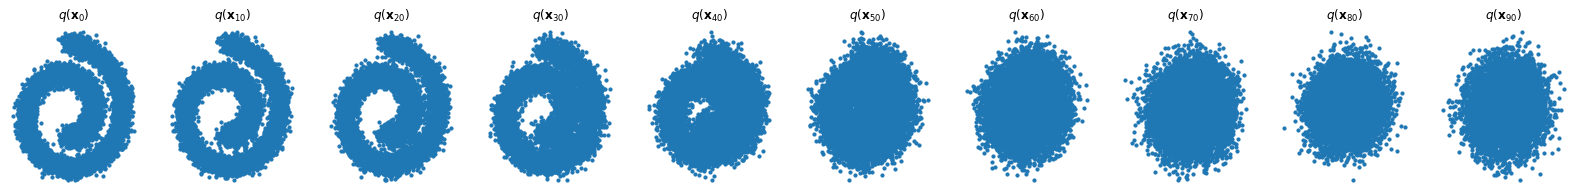

In [4]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_sample(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

在训练时，我们也需要知道这个过程的后验分布的均值和方差：

$$
q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}, \mathbf{x}_{0}\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_{t}}{1-\bar{\alpha}_{t}} \mathbf{x}_{0}+\frac{\sqrt{\alpha_{\iota}}\left(1-\bar{\alpha}_{
t-1}\right)}{1-\bar{\alpha}_{t}} \mathbf{x}_{t}, \tilde{\beta}_{t} I\right)
$$

式中, $ \tilde{\beta}_{t}=\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}} \beta_{t}$

In [5]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

## 3 反向过程

该过程从高斯噪声 $p(\mathbf{x}_{T})=\pi(\mathbf{x}_{T})$ 开始，逐步移除噪声：

$$
p_{\theta}(\mathbf{x}_{0:T}) =  p(\mathbf{x}_{T}) \prod_{t=1}^{T} p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$

这个过程的每一步转换可以看作是条件高斯概率，所以学习时，只需要训练高斯 diffusion kernel 的均值和方差：

$$
p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t),\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t))
$$

均值函数 $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ 和方差函数 $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$ 可以使用神经网络参数化。这些函数是依赖时间步 $t$ 的， 所以所有时间步可以用一个模型来表示。

下面来实现这个过程， 时间步作为模型的输入之一：

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
    
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)
    
model = ConditionalModel(n_steps)
    
def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

可见，反向过程可以推断出每个给定时间步的均值和 log 方差，模型训练完之后，输入 $\mathbf{x}_{t}$ 和 $t$，将会得到 $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ 和 $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$，借此我们就可以为每个时间步解噪。

In [7]:
def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tensor(t))
    noise = torch.randn_like(x)
    shape = [x.shape[0]] + [1] * (x.ndimension() - 1)
    nonzero_mask = (1 - (t == 0))
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample) 

从高斯噪声开始，使用反向马尔可夫链，就可以从模型中逐步得到目标分布。值得注意的是，当时间步很长时，这个过程将十分缓慢。

In [8]:
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

## 4 模型训练

### 4.1 损失函数

模型的全概率表示如下：
$$
p_{\theta}(\mathbf{x}_{0}) = \int p_{\theta}(\mathbf{x}_{0:T})d\mathbf{x}_{1:T}
$$

初步看上去，这个积分是 intractable 的，然而使用类似变分推断的方法，可以写成：

\begin{align}
p_{\theta}(\mathbf{x}_{0}) &= \int p_{\theta}(\mathbf{x}_{0:T})\frac{q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})}{q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})} d\mathbf{x}_{1:T} \\
&= \int q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0}) \frac{p(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}\mid\mathbf{x}_{0})} d\mathbf{x}_{1:T}
\end{align}

对上式使用 Jensen 不等式, 可以优化如下 variational bound 来训练：

\begin{align}
\mathbb{E}\left[-\log p_{\theta}(\mathbf{x}_{0}) \right] & \leq \mathbb{E}_{q}\left[-\log \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T} \mid \mathbf{x}_{0})} \right] \\
\mathcal{L} & = \mathbb{E}_{q}\left[ -\log p(\mathbf{x}_{T}) - \sum_{t\geq 1} \log \frac{p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})}{q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})} \right]
\end{align}

可以使用梯度下降法来优化 $\mathcal{L}$，我们需要先定义一些计算工具：2个高斯分布的 KL散度，高斯分布的熵：

In [9]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + np.log(2. * np.pi))) + 0.5 * np.log(val)

在原始的论文中 Sohl-Dickstein et al. [ [ 1 ] ](#ref1), 损失函数简化为：

\begin{align}
K = -\mathbb{E}_{q}[ &D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}))+ H_{q}(\mathbf{X}_{T}\vert\mathbf{X}_{0}) - H_{q}(\mathbf{X}_{1}\vert\mathbf{X}_{0}) - H_{p}(\mathbf{X}_{T})]
\end{align}

使用高斯分布，损失函数的每一项都可以容易地计算出。

In [10]:
def compute_loss(true_mean, true_var, model_mean, model_var):
    # the KL divergence between model transition and posterior from data
    KL = normal_kl(true_mean, true_var, model_mean, model_var).float()
    
    # conditional entropies H_q(x^T|x^0) and H_q(x^1|x^0)
    H_start = entropy(betas[0].float()).float()
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(alphas))).float()
    H_end = entropy(beta_full_trajectory.float()).float()
    H_prior = entropy(torch.tensor([1.])).float()
    negL_bound = KL * n_steps + H_start - H_end + H_prior
    
    # the negL_bound if this was an isotropic Gaussian model of the data
    negL_gauss = entropy(torch.tensor([1.])).float()
    negL_diff = negL_bound - negL_gauss
    L_diff_bits = negL_diff / np.log(2.)
    L_diff_bits_avg = L_diff_bits.mean()
    return L_diff_bits_avg

### 4.2 训练方法

我们对每个batch 输入随机选择一个时间步来训练，这种训练方式有点违反直觉， [DDIM repo](https://github.com/ermongroup/ddim) 提供了一种 antithetic sampling 形式，可以确保不同链中的对称点联合训练。

最终过程包括首先以给定（随机）时间步长（执行扩散）对每个输入运行前向过程，然后在此样本上运行反向过程，并计算损失。

In [11]:
def loss_likelihood_bound(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the loss
    return compute_loss(true_mean, true_var, model_mean, model_var)

使用上面定义的 loss，可以很方便地训练：

tensor(164.8970, grad_fn=<MeanBackward0>)
tensor(15.5856, grad_fn=<MeanBackward0>)
tensor(9.6094, grad_fn=<MeanBackward0>)
tensor(7.7514, grad_fn=<MeanBackward0>)
tensor(5.3282, grad_fn=<MeanBackward0>)
tensor(6.6088, grad_fn=<MeanBackward0>)


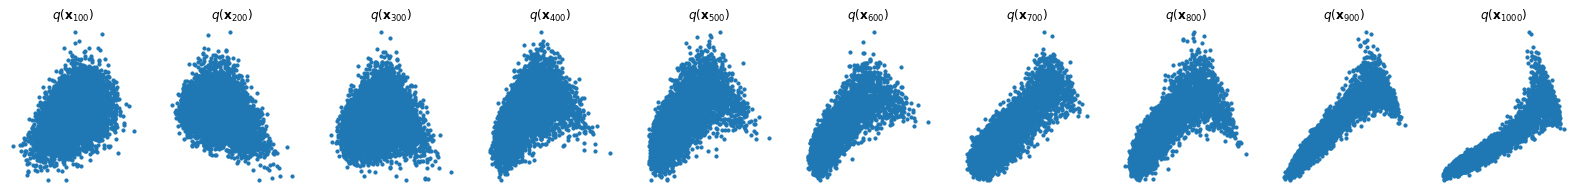

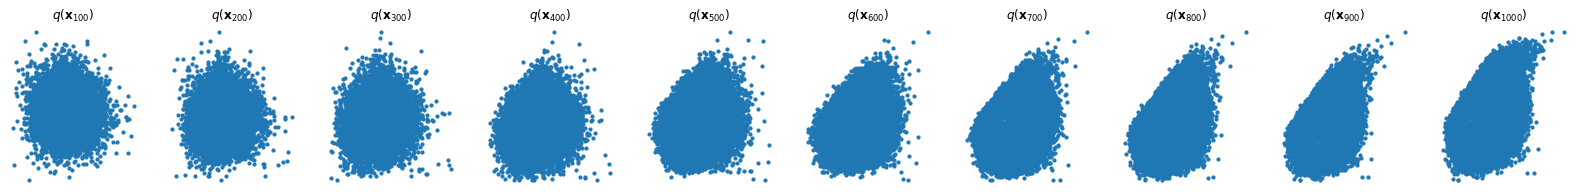

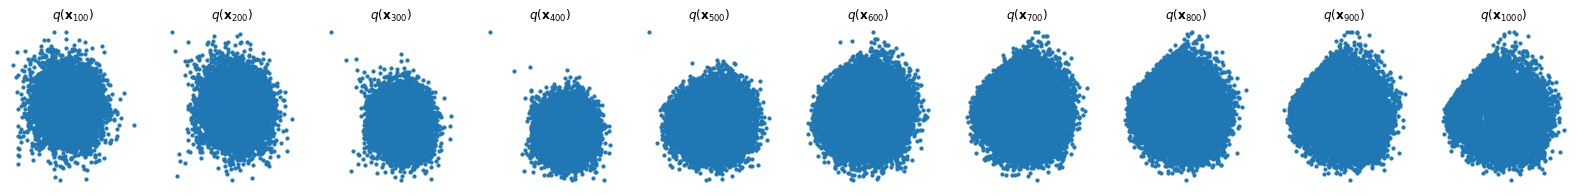

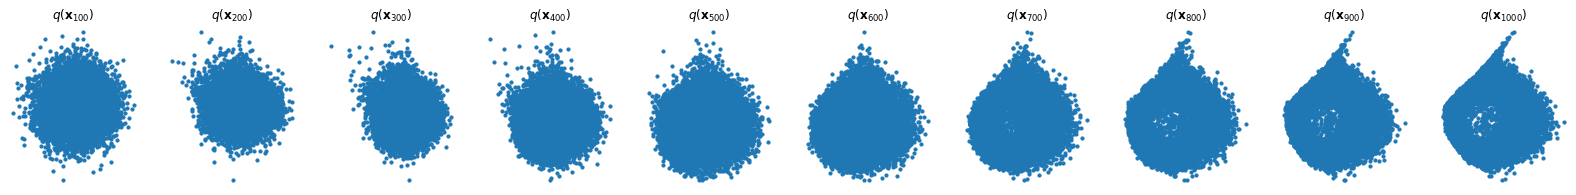

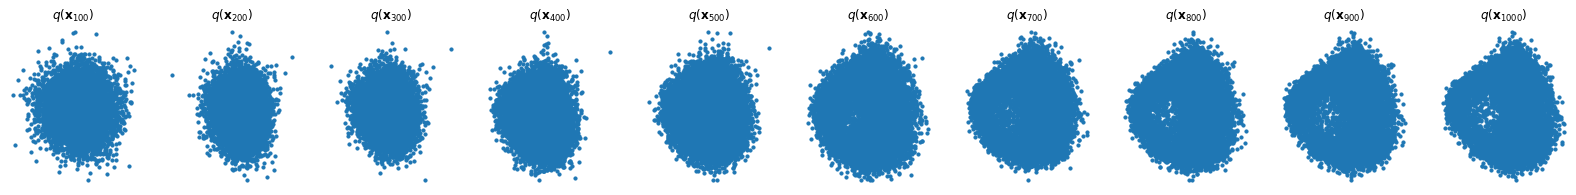

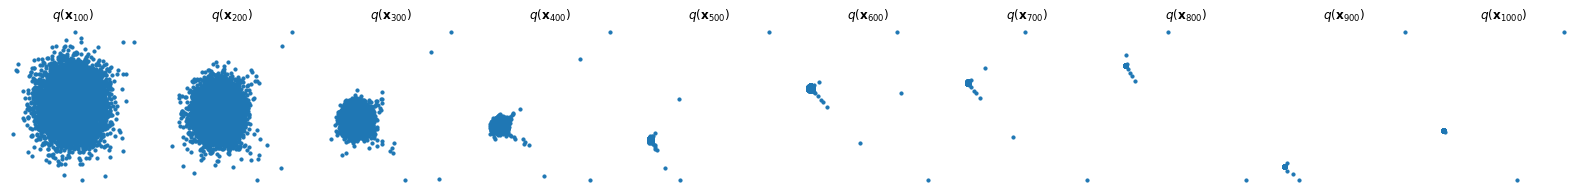

In [12]:
import numpy as np
import torch.optim as optim

model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
batch_size = 128
for t in range(5001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = loss_likelihood_bound(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
    # Print loss
    if (t % 1000 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

## 参考

<a id="ref1"/>

[1] [Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.](https://arxiv.org/pdf/1503.03585)